## 调整文件目录

In [1]:
""" 由于笔记本被收纳到单独的文件夹里，运行时 需且仅需一次 运行本模块来调整工作目录到项目目录下 """
import os


# 获取当前工作目录
current_dir = os.getcwd()
print("Current directory:", current_dir)

# 设置工作目录为上一级目录
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print("New working directory:", os.getcwd())

Current directory: e:\VSCodeFiles\quant\best\notebooks
New working directory: e:\VSCodeFiles\quant\best


## 正文

### 获取数据与数据预处理

In [2]:
import qstock as qs
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt


# 获取沪深300指数从2005年至今的高开低收等行情数据，index是日期
target_code = 'HS300'

data = qs.get_data(code_list=[target_code], start='20050101', freq='d')[['open', 'high', 'low', 'close']]
data.to_csv(f'dataset/test_data/{target_code}_2005_2024.csv')

# 删除名称列、排序并去除空值
data = data.sort_index().fillna(method='ffill').dropna()
# 插入日期列
data.insert(0, 'date', data.index)
# 将日期从datetime格式转换为str格式
data['date'] = data['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
# 按收盘价计算每日涨幅
data['pct'] = data['close'] / data['close'].shift(1) - 1.0
data = data.dropna().reset_index(drop=True)

### 基础RSRS 计算函数

In [5]:
def calculate_beta_in_window(df, window=18):
    if df.shape[0] < window:
        return np.nan
    x = df['low'].values
    y = df['high'].values
    beta = LinearRegression().fit(x.reshape(-1, 1), y).coef_[0]
    return beta


def calculate_beta(df, window=18):
    result = df.copy()
    result['beta'] = [calculate_beta_in_window(_window_data, window=window) for _window_data in result.rolling(window)]

    return result


data = calculate_beta(data)

### RSRS封装版本

In [7]:
from typing import Any
from Modules.Alphas import BaseAlpha


class RSRSAlpha(BaseAlpha):
    def __init__(self, window_size=18) -> None:
        super().__init__()
        self.window_size = window_size
        self.data = None
        
    def calculate_beta_in_window(self, window_data):
        if window_data.shape[0] < self.window_size:
            return np.nan
        x = window_data['low'].values
        y = window_data['high'].values
        beta = LinearRegression().fit(x.reshape(-1, 1), y).coef_[0]
        return beta

    def calculate_beta(self):
        self.data['beta'] = [self.calculate_beta_in_window(_window_data) for _window_data in self.data.rolling(self.window_size)]

        self.data = self.data.copy()
        return self.data
    
    def calculate(self, *args: Any, **kwds: Any) -> Any:
        if args:
            self.data = args[0].copy()
        elif kwds:
            self.data = kwds['df'].copy()
        else:
            return None        
        
        return self.calculate_beta()


data = RSRSAlpha(window_size=18)(df=data)
data

,date,open,high,low,close,pct,beta
0,2005-01-05,981.58,997.32,979.88,992.56,0.009941,NaN
1,2005-01-06,993.33,993.79,980.33,983.17,-0.009460,NaN
2,2005-01-07,983.05,995.71,979.81,983.96,0.000804,NaN
3,2005-01-10,983.76,993.96,979.79,993.88,0.010082,NaN
4,2005-01-11,994.19,999.55,991.09,997.14,0.003280,NaN
...,...,...,...,...,...,...,...
4766,2024-08-16,3342.03,3356.91,3335.62,3345.63,0.001101,0.963803
4767,2024-08-19,3344.26,3375.96,3343.71,3356.97,0.003389,0.942486
4768,2024-08-20,3361.64,3362.33,3321.64,3332.70,-0.007230,0.947533
4769,2024-08-21,3322.91,3339.44,3307.99,3321.64,-0.003319,0.971913


### RSRS numpy 加速版

In [7]:
from Modules.Factors import RSRSFactor, BaseFactor
BaseFactor()

data = RSRSFactor(18, 600)(data)
data

,date,open,high,low,close,pct,beta,r2,zscore,mdf_std_score
0,2005-01-05,981.58,997.32,979.88,992.56,0.009941,NaN,NaN,NaN,NaN
1,2005-01-06,993.33,993.79,980.33,983.17,-0.009460,NaN,NaN,NaN,NaN
2,2005-01-07,983.05,995.71,979.81,983.96,0.000804,NaN,NaN,NaN,NaN
3,2005-01-10,983.76,993.96,979.79,993.88,0.010082,NaN,NaN,NaN,NaN
4,2005-01-11,994.19,999.55,991.09,997.14,0.003280,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
4769,2024-08-21,3322.91,3339.44,3307.99,3321.64,-0.003319,0.971913,0.761505,0.796969,0.606896
4770,2024-08-22,3322.87,3327.70,3305.25,3313.14,-0.002559,1.060887,0.778244,1.558534,1.212920
4771,2024-08-23,3305.93,3336.24,3305.64,3327.19,0.004241,1.085225,0.793002,1.761276,1.396694
4772,2024-08-26,3330.72,3336.53,3311.57,3324.22,-0.000893,1.004564,0.826835,1.064156,0.879882


均值：0.046
标准差：0.865
偏度：0.140
峰度：0.291


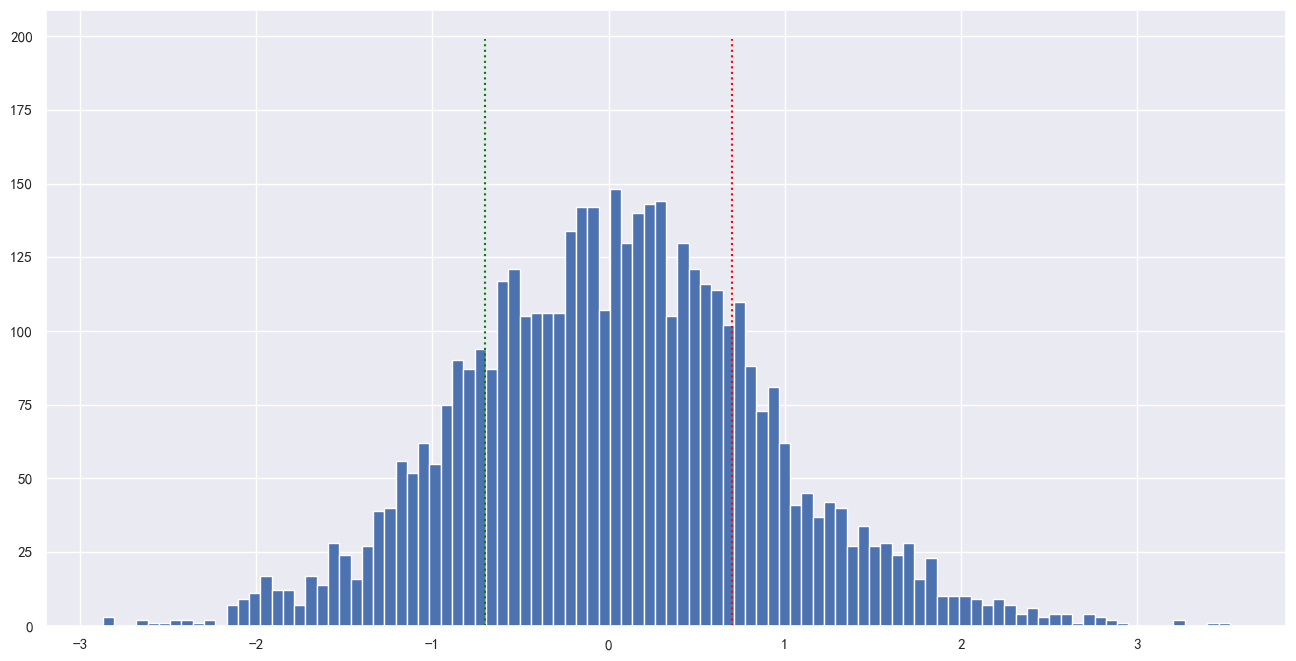

In [76]:
_tgt = 'mdf_std_score'

print('均值：%.3f' %data[_tgt].mean())
print('标准差：%.3f' %data[_tgt].std())
print('偏度：%.3f' %data[_tgt].skew())
print('峰度：%.3f' %data[_tgt].kurt())

y = list(range(200))
plt.figure(figsize=(16,8))
plt.hist(data[_tgt], bins=100)
plt.plot(len(y)*[-0.7], y, color='green', linestyle=':')
plt.plot(len(y)*[0.7], y, color='red', linestyle=':')
plt.show()

In [46]:
data1 = data.dropna().copy().reset_index(drop=True)
data1

,date,open,high,low,close,pct,beta,zscore
0,2007-07-25,4163.36,4256.05,4163.35,4255.46,0.022615,0.876930,-0.457067
1,2007-07-26,4282.68,4325.93,4244.08,4303.19,0.011216,0.895404,-0.298388
2,2007-07-27,4277.55,4318.34,4225.03,4307.14,0.000918,0.902800,-0.235939
3,2007-07-30,4305.18,4426.31,4303.73,4410.30,0.023951,0.924518,-0.046453
4,2007-07-31,4402.52,4467.65,4359.59,4460.56,0.011396,0.946881,0.147710
...,...,...,...,...,...,...,...,...
4150,2024-08-16,3342.03,3356.91,3335.62,3345.63,0.001101,0.963803,0.732669
4151,2024-08-19,3344.26,3375.96,3343.71,3356.97,0.003389,0.942486,0.548797
4152,2024-08-20,3361.64,3362.33,3321.64,3332.70,-0.007230,0.947533,0.589931
4153,2024-08-21,3322.91,3339.44,3307.99,3321.64,-0.003319,0.971913,0.796969


RSRS斜率量化择时策略的年化收益率：8.58%


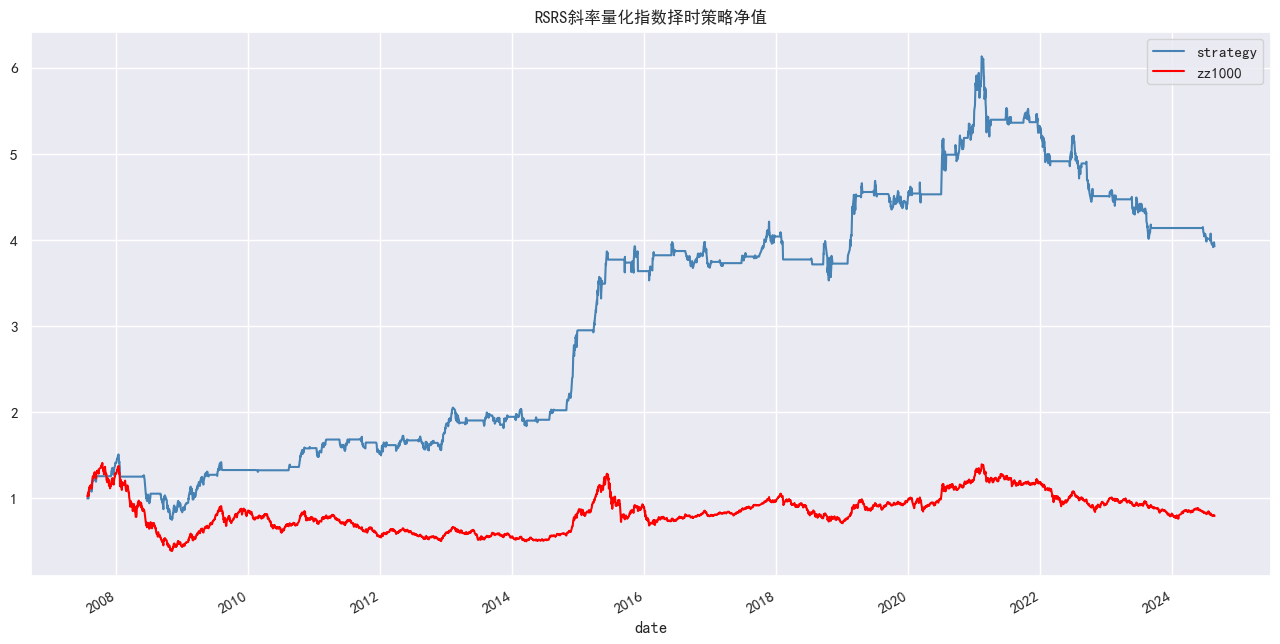

In [47]:
import pandas as pd


buy_thre = 1.0  # 买入阈值
sell_thre = 0.8 # 卖出阈值


data1 = data.dropna().copy().reset_index(drop=True)
 
data1['flag'] = 0 # 买卖标记，买入：1，卖出：-1
data1['position'] = 0 # 持仓状态，持仓：1，不持仓：0
position = 0 
for i in range(1, data1.shape[0]-1):
    beta = data1.loc[i,'beta']
    if (position == 0) and (beta > buy_thre):
        # 若之前无持仓，上穿买入阈值则买入
        data1.loc[i,'flag'] = 1
        data1.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (beta < sell_thre): 
        # 若之前有持仓，下穿卖出阈值则卖出
        data1.loc[i,'flag'] = -1
        data1.loc[i+1,'position'] = 0     
        position = 0
    else:
        # 不触发阈值，则保持原有持仓状态
        data1.loc[i+1,'position'] = data1.loc[i,'position']     
 
# RSRS策略的日收益率
data1['strategy_pct'] = data1['pct'] * data1['position']
 
#策略和沪深300的净值
data1['strategy'] = (1.0 + data1['strategy_pct']).cumprod()
data1['zz1000'] = (1.0 + data1['pct']).cumprod()
 
# 粗略计算年化收益率
annual_return = 100 * (pow(data1['strategy'].iloc[-1], 250/data1.shape[0]) - 1.0)
print('RSRS斜率量化择时策略的年化收益率：%.2f%%' %annual_return)
 
#将索引从字符串转换为日期格式，方便展示
data1.index = pd.to_datetime(data1['date'])
ax = data1[['strategy','zz1000']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS斜率量化指数择时策略净值')
plt.show()


RSRS标准分量化择时策略的年化收益率：15.88%


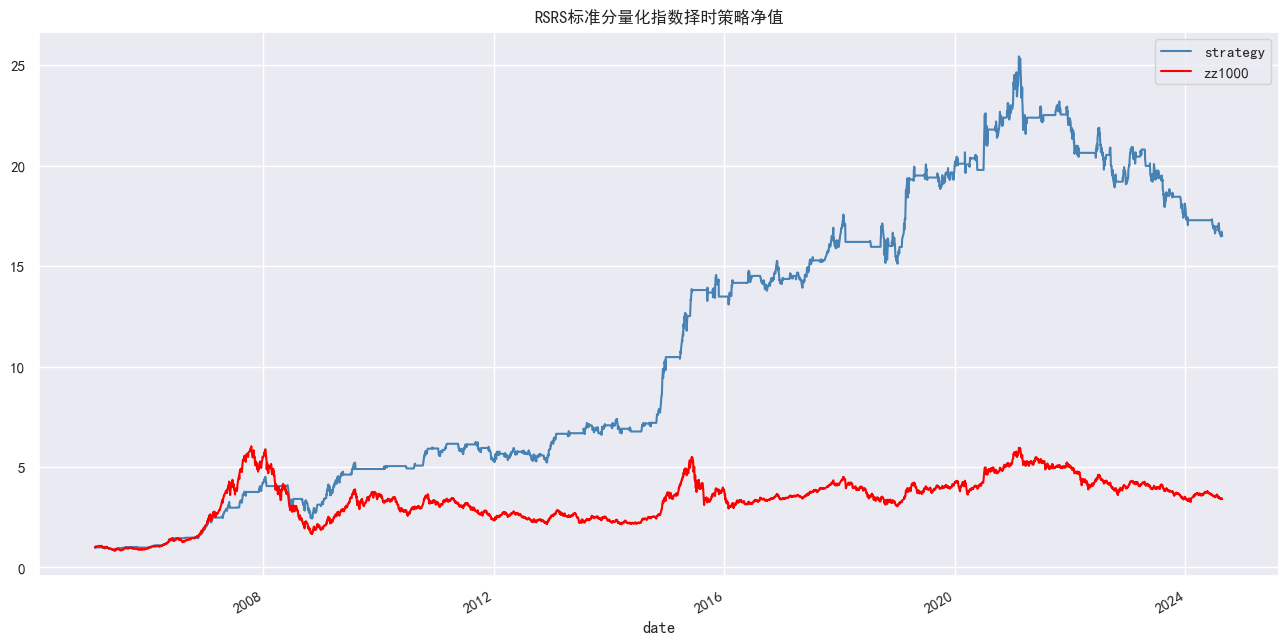

In [8]:
M = 600 # 观察周期
buy_thre = 0.7 # 买入阈值
sell_thre = -0.7 # 卖出阈值
 
data2 = data.dropna().copy().reset_index(drop=True)
# 计算标准分，如果当前时间长度不够，则使用至少20交易日数据计算
data2['std_score'] = (data2['beta'] - data2['beta'].rolling(M, min_periods=20).mean())/data2['beta'].rolling(M, min_periods=20).std()
 
data2['flag'] = 0 # 买卖标记，买入：1，卖出：-1
data2['position'] = 0 # 持仓状态，持仓：1，不持仓：0
position = 0 
for i in range(1, data2.shape[0]-1):
    std_score = data2.loc[i,'std_score']
    if (position == 0) and (std_score > buy_thre):
        # 若之前无持仓，上穿买入阈值则买入
        data2.loc[i,'flag'] = 1
        data2.loc[i+1,'position'] = 1
        position = 1
    elif (position == 1) and (std_score < sell_thre): 
        # 若之前有持仓，下穿卖出阈值则卖出
        data2.loc[i,'flag'] = -1
        data2.loc[i+1,'position'] = 0     
        position = 0
    else:
        # 不触发阈值，则保持原有持仓状态
        data2.loc[i+1,'position'] = data2.loc[i,'position']     
 
# RSRS策略的日收益率
data2['strategy_pct'] = data2['pct'] * data2['position']
 
#策略和沪深300的净值
data2['strategy'] = (1.0 + data2['strategy_pct']).cumprod()
data2['zz1000'] = (1.0 + data2['pct']).cumprod()
 
# 粗略计算年化收益率
annual_return = 100 * (pow(data2['strategy'].iloc[-1], 250/data2.shape[0]) - 1.0)
print('RSRS标准分量化择时策略的年化收益率：%.2f%%' %annual_return)
 
#将索引从字符串转换为日期格式，方便展示
data2.index = pd.to_datetime(data2['date'])
ax = data2[['strategy','zz1000']].plot(figsize=(16,8), color=['SteelBlue','Red'],
                                      title='RSRS标准分量化指数择时策略净值')
plt.show()

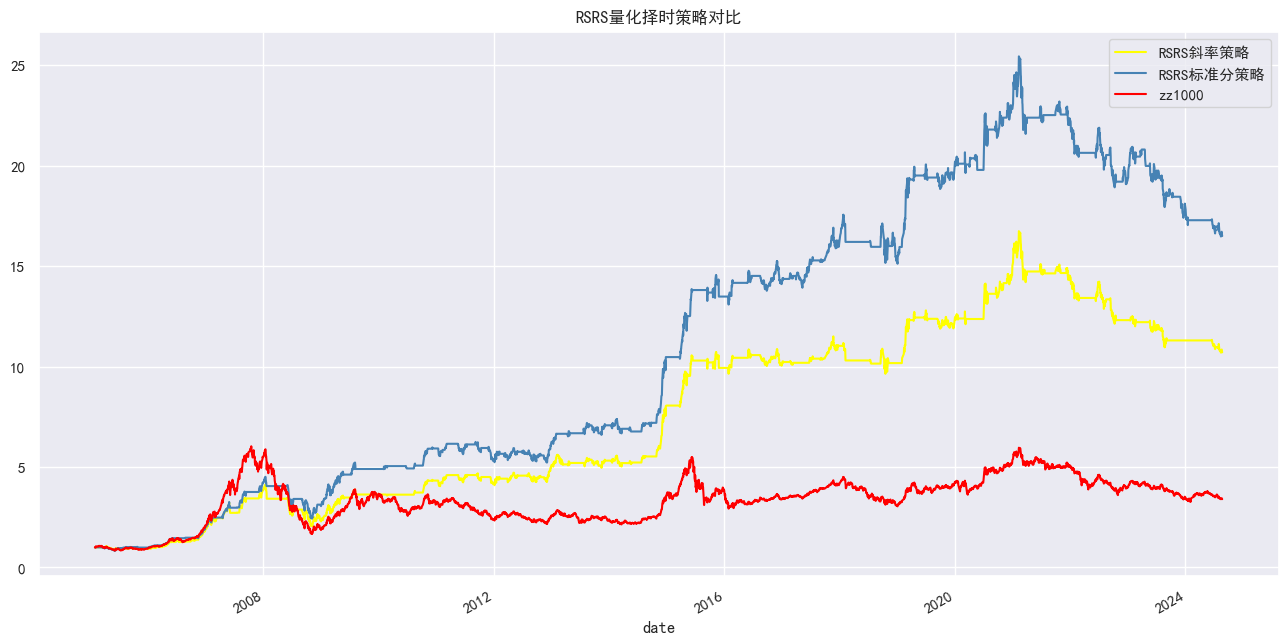

In [9]:
data_merge = pd.merge(data1[['date','strategy']].rename(columns={'strategy':'RSRS斜率策略'}),
                      data2[['strategy','zz1000']].rename(columns={'strategy':'RSRS标准分策略'}),
                      left_index=True, right_index=True, how='inner')
data_merge.index = pd.to_datetime(data_merge['date'])
ax = data_merge[['RSRS斜率策略','RSRS标准分策略','zz1000']].plot(figsize=(16,8), 
                color=['Yellow','SteelBlue','Red'], title='RSRS量化择时策略对比')
plt.show()